## Investigating differences in coverage between TSO and TSID 

In [150]:
import os
import pysam
import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from genepeeks.common import utilities as util
import seaborn as sns
# to clean up later -- temporary fix
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from python_library import DMD_utilities as DMD_util
from python_library import coverage_matrix as cov
import statsmodels.formula.api as sm

%matplotlib inline

In [3]:
# DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
# DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
# # had to make local change in utilities 
# DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=200, include_index=True)
# exon_labels = ['Ex' + exon['index'] for exon in DMD_exons_merged] # this exon label gets used later

DMD_exons_merged, exon_labels = DMD_util.get_DMD_exons_merged()

The following exons were merged: ['65|66']


In [14]:
# DMD exon/gene coordinates and useful regions (coordinates taken from IGV b37 reference)
# EXON46 = [31950197, 31950344]
# EXON47 = [31947713, 31947862]
# EXON48 = [31893308, 31893490]
# EXON49 = [31854835, 31854939]
# EXON50 = [31838092, 31838200]
# EXON51 = [31792077, 31792309]
# DMD = [31115794, 33357558]  # taken from ensembl GRCh37

# deletion of partial exons
EX48_50_PART = [31838130, 31893308]

# for consistency with exon labeling in Ensembl
exon_dict = {exon['index']: [exon['start'], exon['end']] for exon in DMD_exons_merged}
print exon_dict['1'][1] - exon_dict['1'][0]
print exon_dict['1']
print exon_dict['79']

2702
[31137345, 31140047]
[33229399, 33229636]


In [5]:
# workaround to force real time print output in notebooks
# see http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

## Merging bamfiles for subject in mixin experiment (does not need to be run again)

In [179]:
outfiles_0001 = ['FPWB-0001-1232_1-T2', 'FPWB-0001-1232_1-T3', 'FPWB-0001-1232_1-T4', 'FPWB-0001-1232_1-T5']
for name in outfiles_0001:
    full_bam = '../bams/mixin_exp/{}.bam'.format(name)
    component_bams = ['../bams/mixin_exp/{}-1_H5FGFAFXX-L00{}.bam'.format(name, num) for num in range(1,5)]
    pysam.merge(full_bam, *component_bams, catch_stdout=False)
    print 'Finished merging files for {}'.format(name)
    pysam.index(full_bam)

Finished merging files for FPWB-0001-1232_1-T2
Finished merging files for FPWB-0001-1232_1-T3
Finished merging files for FPWB-0001-1232_1-T4
Finished merging files for FPWB-0001-1232_1-T5


## Investigating interval differences between TSO/TSID panels and canonical transcript
Also beginning of creation of superset of exons/intervals to use during Gibbs sampling/assay.

In [189]:
tsid_intervals = pd.read_csv('/Users/velina/Downloads/trusight_inherited_disease_manifest_a.bed', sep='\t', 
                             header=None, names=['chr', 'start', 'end', 'name'])
tso_intervals = pd.read_csv('/Users/velina/Downloads/TruSight_One_v1.1.bed', sep='\t', header=None, 
                            names=['chr', 'start', 'end', 'name'])

intervals = {
    'tsid': {'file': '/Users/velina/Downloads/trusight_inherited_disease_manifest_a.bed'},
    'tso': {'file': '/Users/velina/Downloads/TruSight_One_v1.1.bed'}
}

for name, intrv_info in intervals.items():
    df = pd.read_csv(intrv_info['file'], delimiter='\t', header=None, names=('chrom', 'start', 'end', 'id'))
    intrv_info['X_df'] = df[df['chrom'] == 'chrX'].sort_values(by='start')
    # these coordinates based on the beginning/end of DMD according to tso/tsid exon superset
    intrv_info['dmd_df'] = intrv_info['X_df'][(intrv_info['X_df'].start >= 31137344) & (intrv_info['X_df'].end <= 33357726)]
    intrv_info['intrv_list_X'] = map(dict, dict(intrv_info['X_df'].T).values())
    intrv_info['intrv_list_dmd'] = map(dict, dict(intrv_info['dmd_df'].T).values())

In [190]:
tsid_dmd.head()

,chr,start,end,name
7303,chrX,31137345,31140047,DMD.chrX.31137345.31140047
7304,chrX,31144759,31144790,DMD.chrX.31144759.31144790
7305,chrX,31152219,31152311,DMD.chrX.31152219.31152311
7306,chrX,31164408,31164531,DMD.chrX.31164408.31164531
7307,chrX,31165392,31165635,DMD.chrX.31165392.31165635


In [66]:
# finding interval differences using utilities function
reload(util)
tsid_only = util.interval_diff(intervals['tso']['intrv_list_X'], intervals['tsid']['intrv_list_X'], extend_by=100)
tso_only = util.interval_diff(intervals['tsid']['intrv_list_X'], intervals['tso']['intrv_list_X'], extend_by=100)
print 'TSO only: {} intervals over {} bp'.format(len(tso_only), util.add_intervals(tso_only))
print 'TSID only: {} intervals over {} bp'.format(len(tsid_only), util.add_intervals(tsid_only))

TSO only: 1664 intervals over 358595 bp
TSID only: 207 intervals over 185619 bp


In [71]:
# checking number of intervals in each panel for DMD -- seems to be equal even though some intervals don't match
print len(intervals['tsid']['intrv_list_dmd'])
print len(intervals['tso']['intrv_list_dmd'])

85
85


The method below should not be used for larger genome regions -- not optimized at all, but I wanted a quick and dirty way to find out which intervals in the two panels (or transcript sets) did not match up with an interval in the other set. This method returns full intervals (not interval differences) from both sets that do not have a mate in the other set. Note that even if one interval is much larger than the other, it will still be counted as mated if there is a small overlap between the two sets.

In [191]:
def distinct_intervals(interval_list1, interval_list2, min_overlap=100):
    interval_list1_sort = sorted(copy.deepcopy(interval_list1), key=lambda interval: interval['start'])
    interval_list2_sort = sorted(copy.deepcopy(interval_list2), key=lambda interval: interval['start'])
    
    list1_inc_ind = []
    list2_inc_ind = []
    
    for i, interval in enumerate(interval_list1_sort):
        for i2, interval2 in enumerate(interval_list2_sort):
            if interval['end'] < interval2['start'] or interval['start'] > interval2['end']:
                continue
            else:
                if interval['start'] <= interval2['start'] and interval['end'] >= interval2['end']:
                    list1_inc_ind.append(i)
                    list2_inc_ind.append(i2)
                elif interval['start'] <= interval2['start']:
                    if interval['end'] - interval2['start'] >= min_overlap:
                        list1_inc_ind.append(i)
                        list2_inc_ind.append(i2)
                elif interval['end'] >= interval2['end']:
                    if interval2['end'] - interval['start'] >= min_overlap:
                        list1_inc_ind.append(i)
                        list2_inc_ind.append(i2)
                else:
                    list1_inc_ind.append(i)
                    list2_inc_ind.append(i2)
                            
    list1_match = list(set(list1_inc_ind))
    list2_match = list(set(list2_inc_ind))
    
    list1_only_ind = [ind for ind in range(len(interval_list1_sort)) if ind not in list1_match]
    list2_only_ind = [ind for ind in range(len(interval_list2_sort)) if ind not in list2_match]
    
    list1_only = [interval_list1_sort[ind] for ind in list1_only_ind]
    list2_only = [interval_list2_sort[ind] for ind in list2_only_ind]
#     print list1_inc_ind
#     print list2_inc_ind
#     print interval_list2_sort[53]
    
    return list1_only, list2_only, list1_only_ind, list2_only_ind

In [192]:
# finding distinct intervals in DMD
tso_only_dmd, tsid_only_dmd, tso_only_ind, tsid_only_ind = distinct_intervals(intervals['tso']['intrv_list_dmd'], intervals['tsid']['intrv_list_dmd'], 
                                                                              min_overlap=10)
print 'TSO only: {} intervals over {} bp'.format(len(tso_only_dmd), util.add_intervals(tso_only_dmd))
print 'TSID only: {} intervals over {} bp'.format(len(tsid_only_dmd), util.add_intervals(tsid_only_dmd))
print tsid_only_dmd
print tsid_only_ind

TSO only: 0 intervals over 0 bp
TSID only: 1 intervals over 99 bp
[{'chrom': 'chrX', 'start': 32173488, 'end': 32173586, 'id': 'DMD.chrX.32173488.32173586'}]
[37]


One interval in TSID actually contains two intervals in TSO (DMD.chrX.32430136.32430371) because it includes the untranslated regions of two ending exons for two different transcripts. One interval in TSID is not contained at all in TSO. 

**Now we want to see what overlaps exist between the primary transcript and the TSID intervals.**

In [193]:
prim_trans_only, tsid_exc, prim_trans_ind, tsid_ind = distinct_intervals(DMD_exons_merged, intervals['tsid']['intrv_list_dmd'], 
                                                                          min_overlap=10)
print 'TSID only: {} intervals'.format(len(tsid_exc))
print 'prim_transcript only: {} intervals'.format(len(prim_trans_only))
print tsid_exc
print '\nThe following exons in the TSID panel are NOT included in the canonical DMD transcript'
print list(np.array(tsid_ind) + 1)

TSID only: 6 intervals
prim_transcript only: 0 intervals
[{'chrom': 'chrX', 'start': 31284927, 'end': 31285024, 'id': 'DMD.chrX.31284927.31285024'}, {'chrom': 'chrX', 'start': 31526325, 'end': 31526415, 'id': 'DMD.chrX.31526325.31526415'}, {'chrom': 'chrX', 'start': 32173488, 'end': 32173586, 'id': 'DMD.chrX.32173488.32173586'}, {'chrom': 'chrX', 'start': 32430136, 'end': 32430371, 'id': 'DMD.chrX.32430136.32430371'}, {'chrom': 'chrX', 'start': 33146180, 'end': 33146544, 'id': 'DMD.chrX.33146180.33146544'}, {'chrom': 'chrX', 'start': 33357376, 'end': 33357726, 'id': 'DMD.chrX.33357376.33357726'}]

The following exons in the TSID panel are NOT included in the canonical DMD transcript
[18, 26, 38, 54, 83, 85]


In [136]:
# creating subsets of the tsid interval set for some small experiments in coverage of small regions of DMD
tsid_sorted = sorted(copy.deepcopy(intervals['tsid']['intrv_list_dmd']), key=lambda interval: interval['start'])
for ind, interval in enumerate(tsid_sorted):
    interval['index'] = ind + 1
tsid_subset = tsid_sorted[15:45]
tsid_names = ['tsid_{}'.format(x) for x in range(15, 45)]
# tsid_fullnames = ['tsid_{}'.format(interval['index']) for x in range(len(tsid_sorted))]
print tsid_names

['tsid_15', 'tsid_16', 'tsid_17', 'tsid_18', 'tsid_19', 'tsid_20', 'tsid_21', 'tsid_22', 'tsid_23', 'tsid_24', 'tsid_25', 'tsid_26', 'tsid_27', 'tsid_28', 'tsid_29', 'tsid_30', 'tsid_31', 'tsid_32', 'tsid_33', 'tsid_34', 'tsid_35', 'tsid_36', 'tsid_37', 'tsid_38', 'tsid_39', 'tsid_40', 'tsid_41', 'tsid_42', 'tsid_43', 'tsid_44']


## Exon coverage by panel type

In [125]:
# get full dataset and also subsets based on gender, sequencer, etc
coverage_df = pd.read_csv('../exon_data/coverage_matrix.csv', header=0, index_col=0)
coverage_df.is_rerun.values == False
# remove rerun data
coverage_df = coverage_df[coverage_df.is_rerun == False]
coverage_df.drop('is_rerun', axis=1, inplace=True)
coverage_df.index.name = None
coverage_df.date_modified = pd.to_datetime(coverage_df.date_modified, unit='s')
coverage_df['date'] = coverage_df.date_modified.dt.date
coverage_df_f = coverage_df[coverage_df.gender == 'F']
coverage_df_m = coverage_df[coverage_df.gender == 'M']
# only females in RMA
coverage_df_RMA = coverage_df[coverage_df.subject.str.contains('FRMR')]
coverage_df_M1 = coverage_df[coverage_df.sequencer == 'M1']
grouped_seq = coverage_df.groupby('sequencer')
group_dict = {x: grouped_seq.get_group(x) for x in grouped_seq.groups}
print coverage_df.sequencer.unique()
print coverage_df.shape
coverage_df.head()

['M1' 'P1' 'P3' 'P2' 'T1' 'T4' 'T3' 'T2']
(1230, 91)


,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79,Ex1_coding,Ex79_coding,date
0,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L001,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L001,0.7.15-r1140,2016-10-31 23:15:02,...,77,139,58,63,77,23,81,86,39,2016-10-31
1,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L002,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L002,0.7.15-r1140,2016-10-31 23:15:02,...,57,121,50,95,78,27,67,56,41,2016-10-31
2,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L003,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L003,0.7.15-r1140,2016-10-31 23:15:02,...,52,137,51,78,85,23,38,84,19,2016-10-31
3,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L004,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L004,0.7.15-r1140,2016-10-31 23:15:02,...,71,117,46,76,88,29,56,67,31,2016-10-31
4,MESB-0009-690N_ACGT.1.P1.1,MESB-0009-690N,MESB-0009-690N_ACGT_1,MESB-0009-690N_ACGT.1.P1.1,M,P1,NaN,NaN,0.7.10-r789,2016-06-08 15:49:31,...,74,64,42,50,10,1,6,16,2,2016-06-08


In [19]:
# how many subjects actually included in each sequencing panel set?
for panel, df in group_dict.items():
    print '{}: {}'.format(panel, len(df))

P2: 23
P3: 18
P1: 364
T4: 8
T2: 8
T3: 8
T1: 104
M1: 697


In [93]:
# function for reshaping data frames so that exons are observations (rows) and subjects are variables (columns)
# make sure datetimes have been converted to datetime objects before using
def reshape_df(df, include_stats=False, groupby='subject', subject_droplist=None, df_counts_wanted=False):
    df_grouped = df.groupby([groupby]).sum()
    df_norm = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    df_norm = df_norm.transpose().reset_index()
    df_norm.rename(columns={'index': 'Exon'}, inplace=True)

    if subject_droplist:
        for subject in subject_droplist:
            df_norm.drop(subject, axis=1, inplace=True)
    if include_stats:
        df_norm['Mean'] = df_norm.mean(axis=1)
        df_norm['SD'] = df_norm.std(axis=1)
    if df_counts_wanted:
        return df_norm, df_grouped
    else:
        return df_norm

## Investigating consistency between different T panels and P panels
T panels are TSO and P panels are TSID. Note that the T2-T4 panels here do not correspond to the labels used in the mixin experiment subjects further below. Unclear why these different sets of subjects have similar names. Also unsure what P2-P3 designate but they all seem to be TSID only subjects.

In [194]:
normed_dict = {panel: reshape_df(df, include_stats=True) for panel, df in group_dict.items()}

tso_means = pd.concat([normed_dict['T1'].Mean, normed_dict['T2'].Mean, normed_dict['T3'].Mean, normed_dict['T4'].Mean], axis=1)
tso_means.columns = ['t1', 't2', 't3', 't4']
tso_means.head()

,t1,t2,t3,t4
0,0.016845,0.014012,0.012813,0.012909
1,0.003514,0.002874,0.003533,0.003144
2,0.012617,0.010143,0.009760,0.012048
3,0.016752,0.013427,0.013768,0.013365
4,0.011578,0.008844,0.009217,0.010177


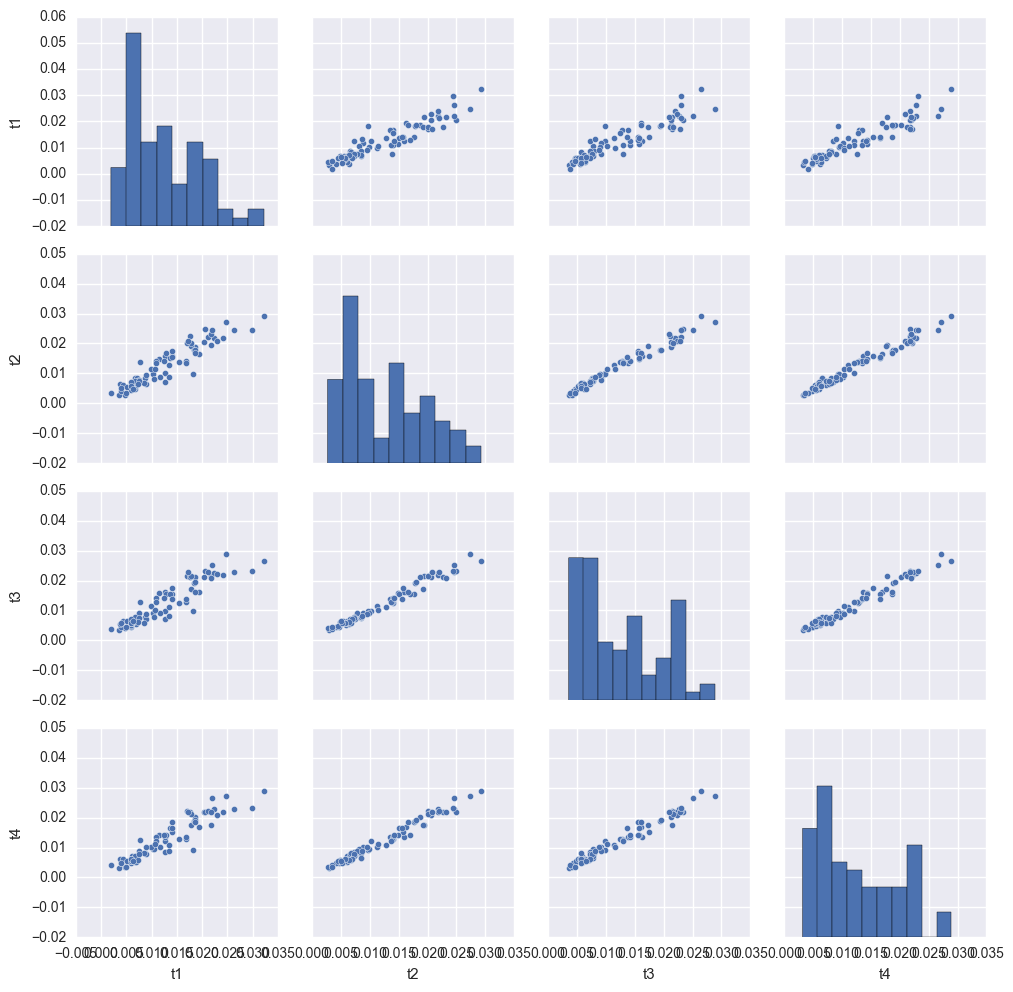

In [195]:
plt.figure()
g = sns.pairplot(tso_means)

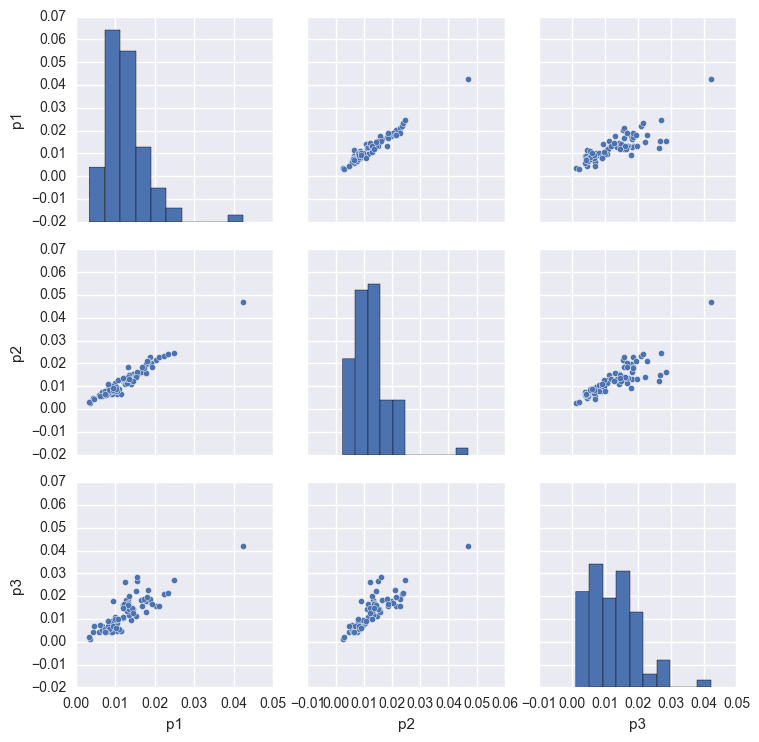

In [196]:
tsid_means = pd.concat([normed_dict['P1'].Mean, normed_dict['P2'].Mean, normed_dict['P3'].Mean], axis=1)
tsid_means.columns = ['p1', 'p2', 'p3']
plt.figure()
g2 = sns.pairplot(tsid_means)

(<matplotlib.text.Text at 0x111c27d90>, <matplotlib.text.Text at 0x111089610>)

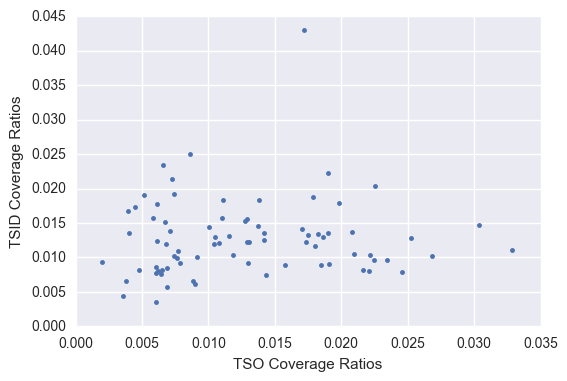

In [26]:
plt.figure()
plt.plot(tso_means.t1, tsid_means.p1, '.')
plt.xlabel('TSO Coverage Ratios'), plt.ylabel('TSID Coverage Ratios')

Coverage ratios between the largest groups of TSO and TSID subjects (T1 and P1 respectively) do not seem to correlate very well, indicating significantly different levels of coverage between the two panels.

## Mix-In Experiment Regression

In [138]:
# the exon of interest is 37 in the tsid panel
# exon 54 is the region that contains the untranslated regions of two first exons
# exons 65/66 which have always been merged are now known as 69/70 in the tsid panel

tsid_exons_merged = util.merge_intervals(tsid_sorted, min_dist=200, include_index=True)
tsid_exon_labels = ['Ex' + exon['index'] for exon in tsid_exons_merged]
print 'The following exons were merged: {}'.format([exon['index'] for exon in tsid_exons_merged if not exon['index'].isdigit()]) 

The following exons were merged: ['53|54', '69|70']


In [180]:
reload(cov)
mixin_exp = cov.coverageMatrix().create_coverage_matrix(tsid_exons_merged, tsid_exon_labels, bam_dir='../bams/mixin_exp')

Finished parsing all 12 subjects
376414 reads were skipped due to outside_of_exon
9005 reads were skipped due to MAPQ below 60


In [181]:
mixin_exp.date_modified = pd.to_datetime(mixin_exp.date_modified, unit='s')
mixin_exp['date'] = mixin_exp.date_modified.dt.date
# drop unnecessary columns (is_rerun, and coding regions)
mixin_exp.drop(['is_rerun'], axis=1, inplace=True)
print mixin_exp.subject.unique()
print mixin_exp.date.unique()

['FGPC-0000-444F' 'FPWB-0000-981L' 'FPWB-0001-1232']
[datetime.date(2017, 2, 28)]


In [130]:
mixin_exp.head()

,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,tsid_36,tsid_37,tsid_38,tsid_39,tsid_40,tsid_41,tsid_42,tsid_43,tsid_44,date
0,FGPC-0000-444F_1-T2-1_H5FGFAFXX-L004,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T2-1,F,T2,H5FGFAFXX,L004,0.7.10-r789,2017-02-28 15:28:23,...,142,107,162,171,123,191,134,158,146,2017-02-28
1,FGPC-0000-444F_1-T2-1_H5FGFAFXX-L002,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T2-1,F,T2,H5FGFAFXX,L002,0.7.10-r789,2017-02-28 15:28:23,...,181,150,152,141,136,212,151,143,130,2017-02-28
2,FGPC-0000-444F_1-T2-1_H5FGFAFXX-L003,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T2-1,F,T2,H5FGFAFXX,L003,0.7.10-r789,2017-02-28 15:28:23,...,154,132,134,177,153,129,161,200,105,2017-02-28
3,FGPC-0000-444F_1-T2-1_H5FGFAFXX-L001,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T2-1,F,T2,H5FGFAFXX,L001,0.7.10-r789,2017-02-28 15:28:23,...,145,136,154,192,130,220,158,172,158,2017-02-28
4,FGPC-0000-444F_1-T3-1_H5FGFAFXX-L001,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-T3-1,F,T3,H5FGFAFXX,L001,0.7.10-r789,2017-02-28 15:35:04,...,167,87,143,158,146,182,182,176,110,2017-02-28


In [109]:
def set_prop_tsid(row):
    if 'T2' in row.name:
        return 0.5
    elif 'T3' in row.name:
        return 0.33
    elif 'T4' in row.name:
        return 0.2
    else:
        return 1.0

In [182]:
mixin_exp_grouped = mixin_exp.groupby('sample').sum()
mixin_norm = mixin_exp_grouped.div(mixin_exp_grouped.sum(axis=1), axis=0)
mixin_norm['tsid_prop'] = mixin_norm.apply(set_prop_tsid, axis=1)
mixin_norm.head()

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex77,Ex78,Ex79,Ex80,Ex81,Ex82,Ex83,Ex84,Ex85,tsid_prop
sample,,,,,,,,,,,,,,,,,,,,,
FGPC-0000-444F_1-T2-1,0.043195,0.004209,0.011617,0.014726,0.009847,0.012837,0.021404,0.017671,0.005905,0.032203,...,0.009639,0.011513,0.008062,0.007407,0.010338,0.004656,0.010814,0.010531,0.027473,0.50
FGPC-0000-444F_1-T3-1,0.036531,0.004933,0.010044,0.015219,0.009512,0.011511,0.021619,0.017153,0.006626,0.031453,...,0.010173,0.013655,0.008432,0.006836,0.010028,0.004707,0.011204,0.008980,0.024585,0.33
FGPC-0000-444F_1-T4-1,0.033073,0.004502,0.010468,0.013413,0.009492,0.011893,0.020560,0.015777,0.005628,0.032041,...,0.009774,0.012587,0.006509,0.007204,0.009905,0.004127,0.009830,0.009248,0.023430,0.20
FGPC-0000-444F_1-T5-1,0.047463,0.003086,0.012808,0.011417,0.007715,0.013994,0.021147,0.017179,0.004462,0.032762,...,0.006689,0.012945,0.009464,0.006910,0.010140,0.005610,0.007921,0.009342,0.025191,1.00
FPWB-0000-981L_1-T2-1,0.039004,0.005274,0.010657,0.013067,0.009876,0.015346,0.021032,0.019014,0.005926,0.030995,...,0.010245,0.012068,0.008270,0.007922,0.010332,0.004558,0.010418,0.009029,0.027869,0.50


In [183]:
# performing the regression after removing the tsid only results (clearly not linear effect then)
mixin_norm2 = mixin_norm[mixin_norm.tsid_prop != 1.0]
regression = sm.ols(formula="Ex38 ~ tsid_prop", data=mixin_norm2).fit()
print regression.params

Intercept    0.002379
tsid_prop    0.011475
dtype: float64


In [184]:
print regression.summary()

                            OLS Regression Results                            
Dep. Variable:                   Ex38   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     81.34
Date:                Tue, 28 Feb 2017   Prob (F-statistic):           4.21e-05
Time:                        18:56:37   Log-Likelihood:                 57.348
No. Observations:                   9   AIC:                            -110.7
Df Residuals:                       7   BIC:                            -110.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0024      0.000      5.127      0.0

/Users/velina/.pyenv/versions/2.7.11/envs/dmd/lib/python2.7/site-packages/scipy/stats/stats.py:1326: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


## Plotting coverage ratio of various exons as function of TSID proportion
Note that Exon 38 (first one) is the only one that appears exclusively in TSID.

(<matplotlib.text.Text at 0x10df3ff90>, <matplotlib.text.Text at 0x10dec9a50>)

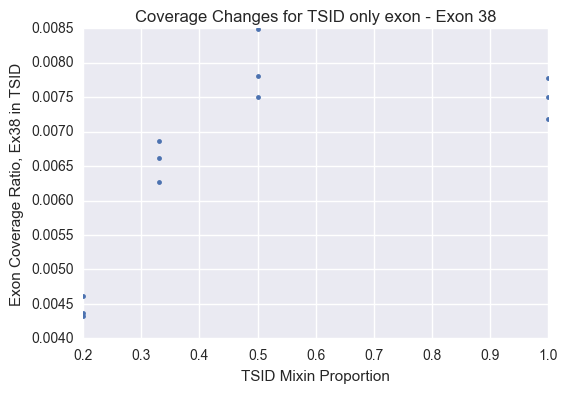

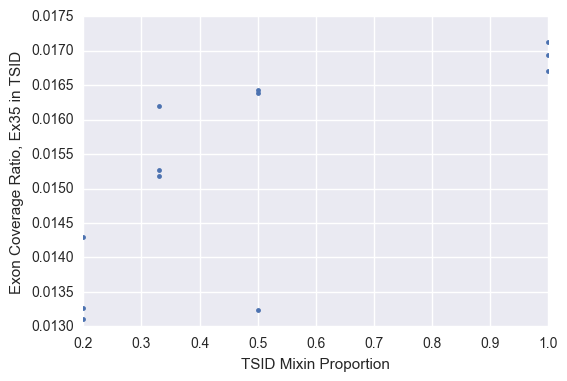

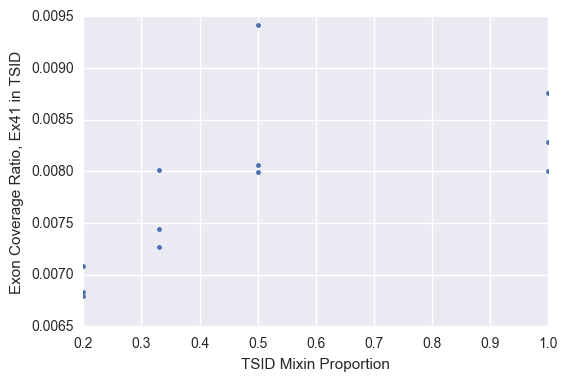

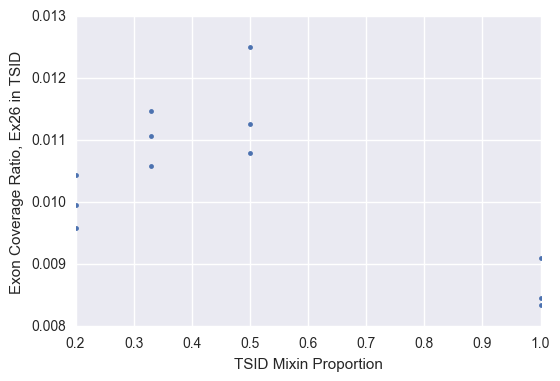

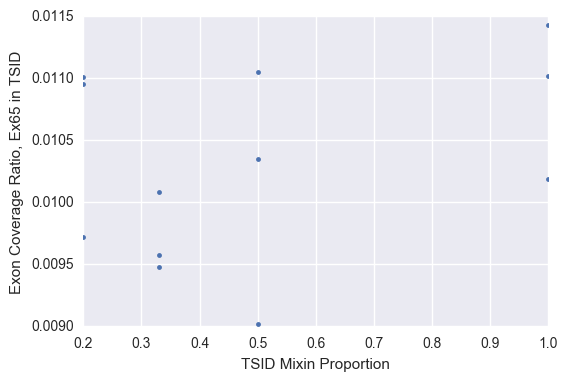

In [188]:
plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex38, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex38 in TSID')
plt.title('Coverage Changes for TSID only exon - Exon 38')

plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex35, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex35 in TSID')

plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex41, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex41 in TSID')

plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex26, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex26 in TSID')

plt.figure()
plt.plot(mixin_norm.tsid_prop, mixin_norm.Ex65, '.')
plt.xlabel('TSID Mixin Proportion'), plt.ylabel('Exon Coverage Ratio, Ex65 in TSID')

## Gibbs Sampling


The full gene product of DMD consists of 78 exons, each with its own copy number in each subject ($\mathbf{C} = \{c_1, c_2, ..., c_{78}\}$), where $c_i \in{1,2,3...}$ For this simple model, assume that the $c_i$ are distributed discrete uniformly with support $ \{1,2,3\}$. 

We also know "intensity" values across the exons $\mathbf{X}= \{x_1, x_2,..., x_{78}\}$, and we let $$\mathbf{P} = \dfrac{\mathbf{C}\mathbf{X}}{\sum_i c_ix_i} = \{p_1, p_2, ..., p_{78}\}$$ 

This generates probability values for the multinomial distribution from which we will sample the reads for a single simulated "sequencing run". 

Initialize the intensities $\mathbf{X}$ (see X_probs above). Initialize $c_i$ values based on basic prior distribution. Assume 5000 reads per sample/subject and initialize a single sequencing run $Y = \{y_1, y_2, ... y_{78}\}$. When testing a real subject's data, we still use the known $\mathbf{X}$ but use data $Y$ from the subject where $y_i$ represents the number of reads mapped to exon $i$.

At each iteration $t$, sample $c_i^t$ from the posterior distribution
$$f_{C^t|Y, C_{-i}^t}(c) = \dfrac{\Pi_{j=1}^{78} (p_j|c_i=c)^{y_j}}{\sum_c \Pi_{j=1}^{78} (p_j|c_i=c)^{y_j}} $$ 
where $$ C_{-i}^t = \{ c_1^t,...c_{i-1}^t, c_{i+1}^{t-1}, ... c_{78}^{t-1} \}$$

Normally this expression would include the prior distribution over $c$ but it easily cancels out as the uniform. (This expression also does not include the multinomial constant). 

**Implementation considerations**: $\Pi_j (p_j|c_i=c)^{y_j}$ can cause under/overflow in Python (or washout of values too close to 0), but trying to use the log of the posterior distribution leads to 
$$  \sum y_j \log (p_j|c_i=c) - \log \sum \Pi_j (p_j|c_i=c)^{y_j}$$

**Solution**: Convert to log space and divide by the maximal likelihood to normalize (and keep values from shrinking too close to 0):
$$ \dfrac{\exp\left(\sum y_j \log (p_j|c_i=c) - \max_c \sum y_j \log (p_j|c_i=c)\right)}{\sum_c \exp\left(\sum y_j \log (p_j|c_i=c) - \max_c \sum y_j \log (p_j|c_i=c)\right)}$$ 

Store the $C^t$ values only for iterations $t=1000... 10,000$. This allows for a burn-in period of 1000 iterations during which the sampling distributions are likely to be least accurate. To reduce auto-correlation, only include every hundredth sampling in final analysis as well. For each exon $i$, count the proportions of samples falling into each possible copy number across the relevant subset of iterations. 


### Next Steps
* Incorporate more complex and representative prior for the copy number distribution (in particular, there should be higher prior probability for 2 copies of exon)
* Determine more accurate estimate of burn-in period (strange log-likelihood behavior, should converge as iterations increase)
* Account for increased likelihood of copy number correlation between neighboring exons
* Consider modifying prior for two exon deletion hotspots (around 45-50 and 18-20)
* **Incorporate step for correcting for mixin-based discrepancies**


In [395]:
def generate_gibbs_df(cnv_support, X_probs, data=None, cnv=None, total_reads=5000, iterations=10000, burn_in=1000):
    '''Performs Gibbs sampling given a support vector for CNVs, an intensity vector and subject data (optional)'''
    if cnv is None:
        # generate initial guess for exon copy numbers using uniform prior distribution
        cnv = np.random.choice(cnv_support, size=len(X_probs)) 
    print cnv 
    normed_probs_first = np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs))
    if data is None:
        data = np.random.multinomial(total_reads, normed_probs_first)
    gibbs_data = np.zeros((len(X_probs), iterations))
    
    likelihoods = np.zeros(iterations)
    for i in range(iterations):
        if (i+1) % (iterations / 20) == 0:
            print 'Finished {} iterations'.format(i)
        for exon in range(len(X_probs)):
            test = np.zeros(len(cnv_support))
            for value in cnv_support:
                cnv[exon] = value
                # get new normed probabilities given test value
                normed_probs_test = np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs)) 
                log_likelihood =  np.sum(np.multiply(np.log(normed_probs_test), data))
                test[value - 1] = log_likelihood
            test = test - np.max(test)
            sample_probs = np.exp(test)
            sample_probs = sample_probs / np.sum(sample_probs)
            new_cnv = np.random.choice(cnv_support, p = sample_probs)
            cnv[exon] = new_cnv
            gibbs_data[exon, i] = new_cnv
        log_probs = np.log(np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs)))
        likelihoods[i] = np.sum(np.multiply(log_probs, data))
    
    # get proportions using burn-in of 1000 iterations 
    gibbs_data_results = np.zeros((len(X_probs), len(cnv_support)))
    for index in range(len(X_probs)):
        # exclude samples before burn in and then take only every 100th sample to reduce autocorrelation
        gibbs_slice = gibbs_data[index][burn_in:][::100]
        gibbs_data_results[index] = np.bincount(gibbs_slice.astype(np.int64), 
                                                minlength=len(cnv_support)+1)[1:]
    gibbs_data_results = gibbs_data_results / float(len(gibbs_slice))
    
    gibbs_df = pd.DataFrame(gibbs_data_results, columns =['copy_{}'.format(cnv) for cnv in cnv_support])
    gibbs_df['Exon'] = exon_labels
    
    return gibbs_data, gibbs_data_results, likelihoods, gibbs_df

## Rerunning Gibbs Sampling with superset of exons (from TSID)

In [390]:
# use RMA samples for initial intensity vector -- note that all RMA individuals used the M1 mixin panel
# this is only the females in RMA
print coverage_df_RMA.sequencer.unique()
RMA_norm = reshape_df(coverage_df_RMA, include_stats=True)
RMA_norm.head()
X_probs = np.array(RMA_norm.Mean)
print len(X_probs)
X_probs
RMA_norm.head()

['M1']
78


subject,Exon,FRMR-0070-444H,FRMR-0081-1987,FRMR-0085-579V,FRMR-00AG-860T,FRMR-00AW-8645,FRMR-00BB-772T,FRMR-00CS-821F,FRMR-00DM-853C,FRMR-00GC-803L,...,FRMR-00MS-704S,FRMR-00NC-7632,FRMR-00SA-876L,FRMR-00SB-851W,FRMR-00SC-714V,FRMR-00SD-679G,FRMR-00ST-841F,FRMR-00TS-8464,Mean,SD
0,Ex1,0.043410,0.046888,0.041839,0.047436,0.042754,0.044030,0.043325,0.044394,0.049125,...,0.047474,0.049913,0.041827,0.043412,0.047473,0.040683,0.049380,0.044282,0.045890,0.002980
1,Ex2,0.001823,0.001920,0.001819,0.001878,0.002115,0.001833,0.001460,0.001570,0.001887,...,0.001696,0.001457,0.001612,0.001898,0.001795,0.002227,0.002079,0.001681,0.001813,0.000274
2,Ex3,0.011077,0.011095,0.010518,0.009593,0.010601,0.011386,0.010802,0.011919,0.011628,...,0.011040,0.010678,0.011174,0.011885,0.010244,0.009834,0.012735,0.011960,0.011160,0.000778
3,Ex4,0.018180,0.017203,0.017662,0.023065,0.016674,0.015053,0.021078,0.018842,0.019988,...,0.020950,0.020907,0.018906,0.017222,0.018785,0.015447,0.021608,0.020530,0.019189,0.002110
4,Ex5,0.010451,0.011308,0.011741,0.013880,0.009930,0.010047,0.012904,0.012455,0.010619,...,0.010690,0.009108,0.011037,0.010289,0.010058,0.011319,0.011138,0.010895,0.011041,0.001030


In [159]:
reload(cov)
test_subjects_num = cov.coverageMatrix().create_coverage_matrix(tsid_exons_merged, 
                                                                tsid_exon_labels, bam_dir='../bams/test_subjects')

Finished parsing all 6 subjects
165124 reads were skipped due to outside_of_exon
4612 reads were skipped due to MAPQ below 60


In [161]:
# test_subjects = pd.DataFrame(coverage_matrix[1:], columns=coverage_matrix[0])
# test_subjects_num = test_subjects.apply(lambda x: pd.to_numeric(x, errors='ignore'))
test_subjects_num.date_modified = pd.to_datetime(test_subjects_num.date_modified, unit='s')
test_subjects_num['date'] = test_subjects_num.date_modified.dt.date
# drop unnecessary columns (is_rerun, and coding regions)
test_subjects_num.drop(['is_rerun'], axis=1, inplace=True)
print test_subjects_num.subject.unique()
print test_subjects_num.date.unique()
#test_subjects_num.head(25)

['FGPC-0000-444F' 'FGPC-0000-444F_dup' 'FGPC-4ZPF-J0F1'
 'FGPC-4ZPF-J0F1_del' 'FPWB-0000-822R' 'FPWB-0000-822R_del']
[datetime.date(2016, 6, 24) datetime.date(2017, 2, 17)
 datetime.date(2016, 6, 25)]


In [162]:
subject_norm = reshape_df(test_subjects_num)
subject_norm.head()

subject,Exon,FGPC-0000-444F,FGPC-0000-444F_dup,FGPC-4ZPF-J0F1,FGPC-4ZPF-J0F1_del,FPWB-0000-822R,FPWB-0000-822R_del
0,Ex1,0.036531,0.036425,0.044187,0.044841,0.041012,0.041913
1,Ex2,0.004933,0.004919,0.003162,0.003209,0.003544,0.003621
2,Ex3,0.010044,0.010014,0.010316,0.010469,0.010452,0.010682
3,Ex4,0.015218,0.015174,0.014952,0.015174,0.015424,0.015763
4,Ex5,0.009528,0.009500,0.010129,0.010279,0.008474,0.008661


In [174]:
# getting coverage for Exon38 for these test subjects
exon38 = subject_norm.iloc[37]
print exon38[1:]

subject
FGPC-0000-444F        0.00627116
FGPC-0000-444F_dup    0.00625301
FGPC-4ZPF-J0F1        0.00560036
FGPC-4ZPF-J0F1_del    0.00568336
FPWB-0000-822R        0.00582354
FPWB-0000-822R_del    0.00595155
Name: 37, dtype: object


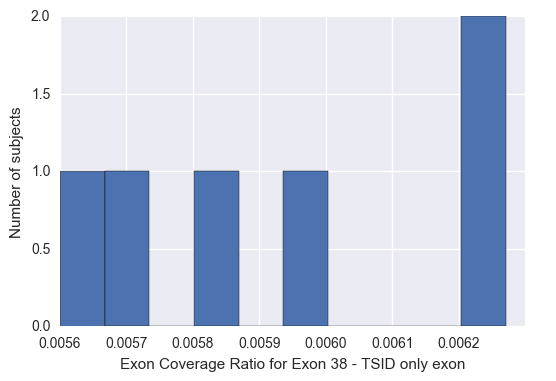

In [178]:
# seeing distribution of Exon38 coverage -- we expect three pairs since each simulated mut subject should have similar 
# coverage to its original subject
plt.figure()
plt.hist(exon38[1:])
plt.xlabel('Exon Coverage Ratio for Exon 38 - TSID only exon')
plt.ylabel('Number of subjects')

In [200]:
# get estimated TSID proportion for each subject based on regression coefficients from above -- all should be near 0.33
estimate_prop = (exon38[1:] - regression.params[0]) / regression.params[1]
print estimate_prop

subject
FGPC-0000-444F        0.339219
FGPC-0000-444F_dup    0.337637
FGPC-4ZPF-J0F1        0.280759
FGPC-4ZPF-J0F1_del    0.287993
FPWB-0000-822R        0.300209
FPWB-0000-822R_del    0.311365
Name: 37, dtype: object
